In [1]:
# imports 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV
from collections import Counter
from tqdm.notebook import tqdm
from sklearn.linear_model import Lasso, LinearRegression, LassoCV, ElasticNet, Ridge
from sklearn.metrics import get_scorer_names, mean_squared_error, r2_score, f1_score
from sklearn.datasets import make_regression
import scipy.stats as stats

from pytensor.tensor import TensorVariable
from typing import Optional, Tuple

import pymc as pm
import arviz as az



WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Regression simulation function

In [2]:
def CreateRegression(Fcount = 10, relevant_count = 5, sig_strength = 0.6):

        # get bias term from normal dist N(0,1)
        bias = np.random.default_rng().normal(0,1)

        # get features from normal dist N(0,1)
        X = np.random.default_rng().normal(0,1,(16,Fcount))

        # init params for weight dist (N(0,1) where |X|>sig_strength)
        mu=0
        sigma=1
        # Get a truncated normal distribution N(0,1)
        W1 = (stats.truncnorm((sig_strength - mu) / sigma,  np.inf, loc=mu, scale=sigma).rvs(size=(relevant_count))  
                # multiply with modified bernoullie (-1 or 1) to create dual-sided truncated normal dist
                * ((stats.bernoulli(0.5).rvs(size=(relevant_count)) *2) - 1))

        # get other weights from 'point mass' at 0 (tiny normal dist N(0,.001))
        W2 = np.random.default_rng().normal(0, 0.001, Fcount-relevant_count)

        # get all weights by combining relevant and irrelevant weights
        W = np.concatenate([W1, W2])

        # get error terms from even smaller normal dist
        er = np.random.default_rng().normal(0, 0.0001, 16)


        # create regression
        y = bias + sum(W.reshape(-1,1)*X.T + er)

        #  scale feats and target
        X = StandardScaler().fit_transform(X)
        y = StandardScaler().fit_transform(y.reshape(-1, 1)).squeeze()

        return X, y

Model initialization

In [4]:
def get_model(y, X):
    model = pm.Model()
    # Sigma = .5 * np.matmul(X.T, X)
    # Sigma += np.diag(np.diag(Sigma))
    # Sigma = np.linalg.inv(Sigma)
    Sigma = np.identity(X.shape[1])
    with model:
        xi = pm.Bernoulli('xi', .5, shape=X.shape[1])
        tau = pm.HalfCauchy('tau', 1)
        sigma = pm.HalfNormal('sigma', 10)
        beta = pm.MvNormal('beta', 0, tau * Sigma, shape=X.shape[1])
        mean = pm.math.dot(X, xi * beta)
        y_obs = pm.Normal('y_obs', mean, sigma, observed=y)
    return model

# 10

In [6]:
Fcount = 10

X,y = CreateRegression(Fcount = Fcount)

(16,)


array([-8.630e-01, -1.382e+00,  7.780e-01,  7.010e-01,  7.260e-01,
        1.000e-03,  1.000e-03, -1.000e-03, -1.000e-03,  0.000e+00])

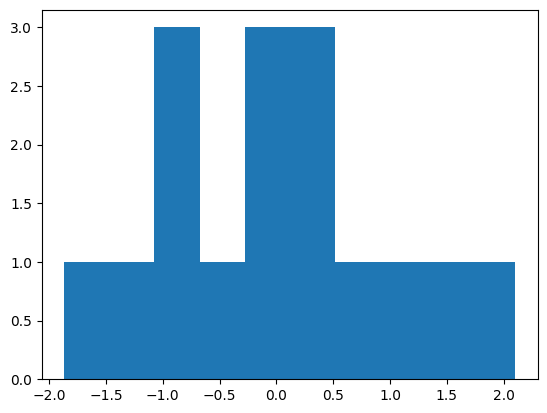

In [53]:
print(y.shape)
plt.hist(y)

W.round(3)

In [7]:
model1 = get_model(y, X)
# model1 = get_model(y.to_numpy(), X.to_numpy())


with model1:
    trace = pm.sample(5000, tune=500, random_seed = 4816, cores = None, progressbar = True, chains = None, target_accept=0.95)
    idata = pm.sample_prior_predictive(samples=50, random_seed=43)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [xi]
>NUTS: [tau, sigma, beta]


In [56]:
with model1:
    idata.extend(pm.sample(5000, tune=500, random_seed=43, target_accept=0.95))

# az.plot_trace(idata)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [xi]
>NUTS: [tau, sigma, beta]


Sampling 4 chains for 500 tune and 5_000 draw iterations (2_000 + 20_000 draws total) took 263 seconds.
/cluster/home/jmcint09/condaenv/testenv/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 3194 divergences after tuning. Increase `target_accept` or reparameterize.


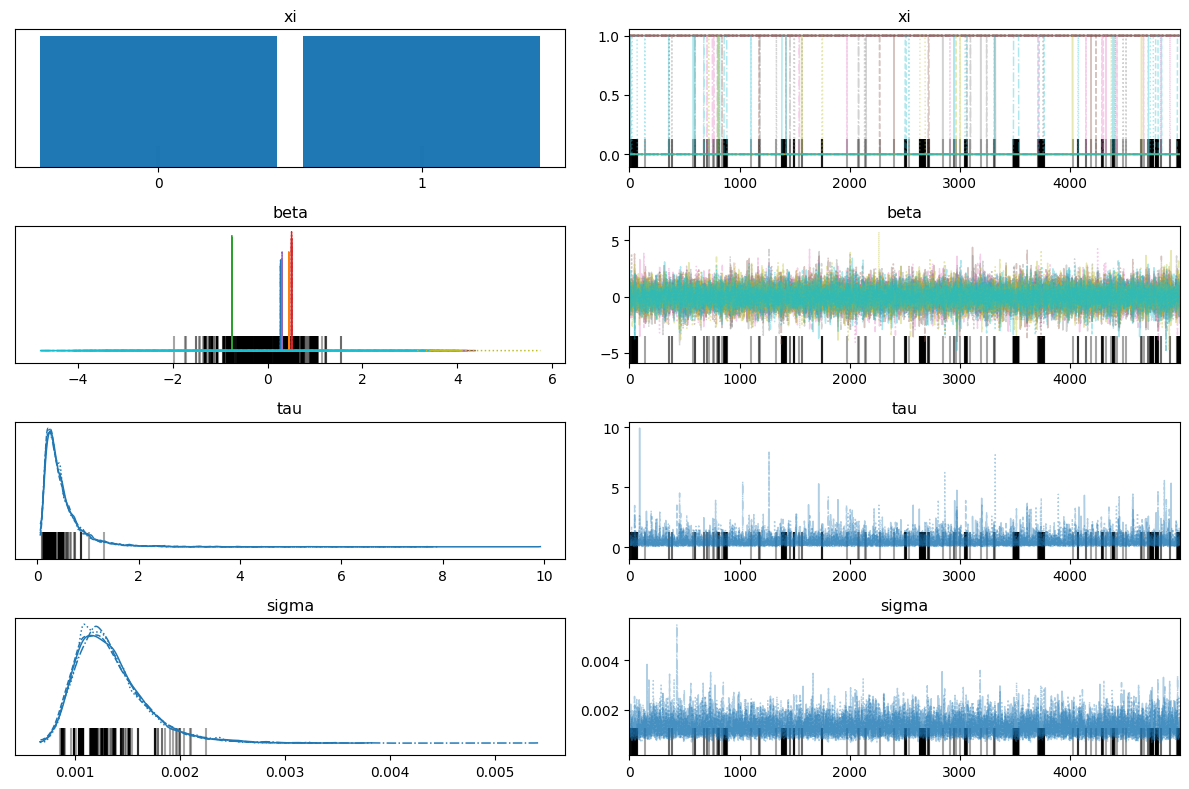

In [57]:
az.plot_trace(trace)
plt.tight_layout()

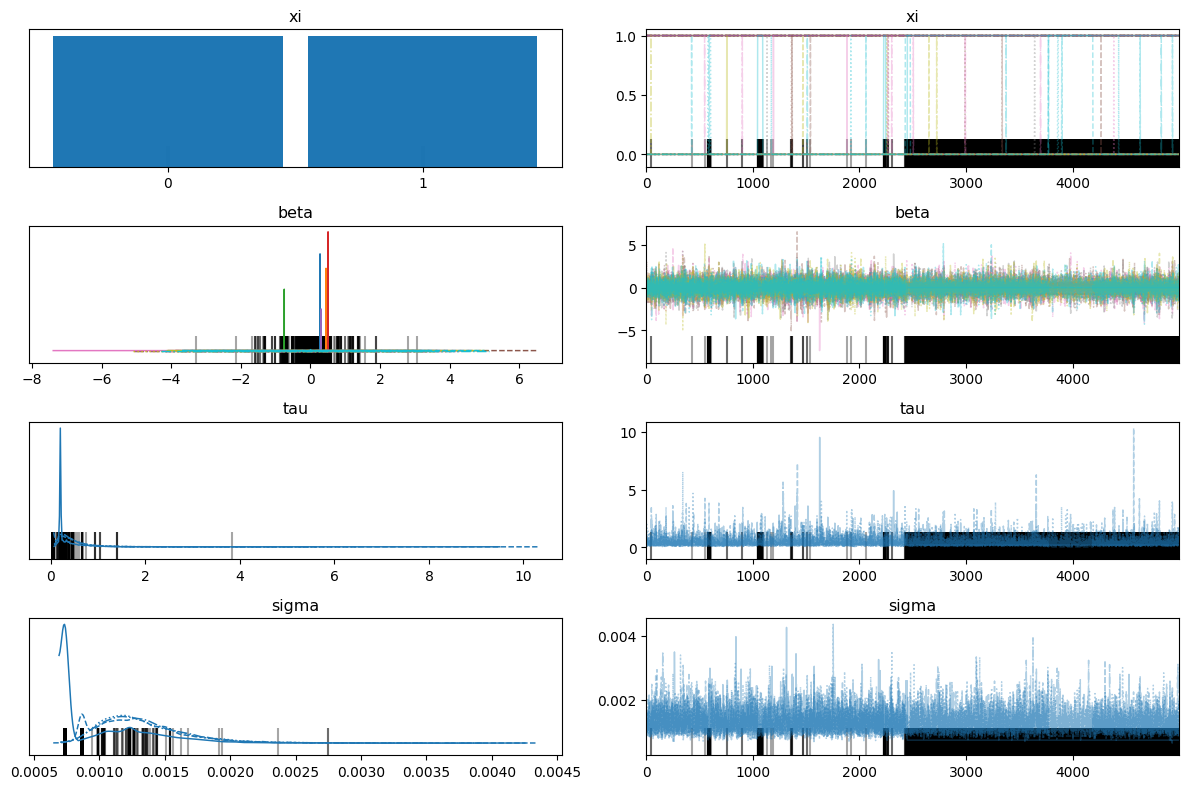

In [58]:
az.plot_trace(idata)
plt.tight_layout()

In [59]:
with model1:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=43)

Sampling: [y_obs]


<AxesSubplot: xlabel='y_obs / y_obs'>

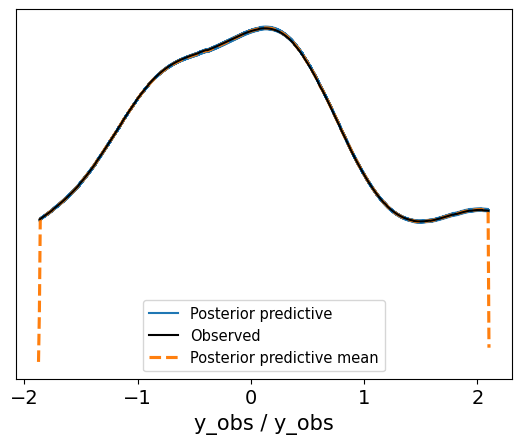

In [60]:
az.plot_ppc(idata)

In [61]:
# az.summary(trace)


In [62]:
results = pd.DataFrame({'var': np.arange(Fcount), 
                        'inclusion_probability':np.mean(np.apply_along_axis(np.mean, 1, trace.posterior['xi']), axis=0),
                       'beta':np.mean(np.apply_along_axis(np.mean, 1, trace.posterior['beta']), axis=0),
                    #    'beta_given_inclusion': np.apply_along_axis(np.sum, 0, trace['xi']*trace['beta'])
                    #         /np.apply_along_axis(np.sum, 0, trace['xi'])
                       })

In [63]:
results.sort_values('inclusion_probability', ascending = False).head(10)


,var,inclusion_probability,beta
0,0,1.00000,0.275884
1,1,1.00000,0.448529
2,2,1.00000,-0.752352
3,3,1.00000,0.506663
4,4,1.00000,0.306926
9,9,0.01695,-0.001978
8,8,0.00325,0.000423
7,7,0.00155,-0.010092
6,6,0.00125,0.001746
5,5,0.00080,-0.000697


# 40

In [2]:
Fcount = 40

X,y = CreateRegression(Fcount = Fcount)

(16,)


array([-8.850e-01,  1.057e+00, -9.440e-01, -1.266e+00,  1.104e+00,
       -1.000e-03,  1.000e-03,  0.000e+00, -1.000e-03, -0.000e+00,
        0.000e+00, -1.000e-03,  1.000e-03, -0.000e+00, -1.000e-03,
        2.000e-03, -0.000e+00,  0.000e+00, -2.000e-03, -0.000e+00,
        0.000e+00, -0.000e+00, -0.000e+00,  1.000e-03, -0.000e+00,
       -1.000e-03, -1.000e-03, -1.000e-03, -0.000e+00,  1.000e-03,
        0.000e+00, -0.000e+00,  1.000e-03,  2.000e-03,  1.000e-03,
        0.000e+00,  0.000e+00,  2.000e-03, -1.000e-03, -1.000e-03])

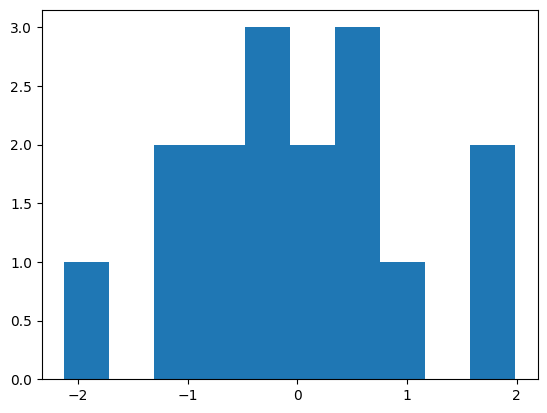

In [3]:
print(y.shape)
plt.hist(y)

W.round(3)

In [5]:
model1 = get_model(y, X)
# model1 = get_model(y.to_numpy(), X.to_numpy())


with model1:
    trace = pm.sample(5000, tune=500, random_seed = 4816, cores = None, progressbar = True, chains = None, target_accept=0.95)
    idata = pm.sample_prior_predictive(samples=50, random_seed=43)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [xi]
>NUTS: [tau, sigma, beta]


Sampling 4 chains for 500 tune and 5_000 draw iterations (2_000 + 20_000 draws total) took 4354 seconds.
/cluster/home/jmcint09/condaenv/testenv/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1287 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sa

In [6]:
with model1:
    idata.extend(pm.sample(5000, tune=500, random_seed=43, target_accept=0.95))

# az.plot_trace(idata)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [xi]
>NUTS: [tau, sigma, beta]


Sampling 4 chains for 500 tune and 5_000 draw iterations (2_000 + 20_000 draws total) took 5288 seconds.
/cluster/home/jmcint09/condaenv/testenv/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1566 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


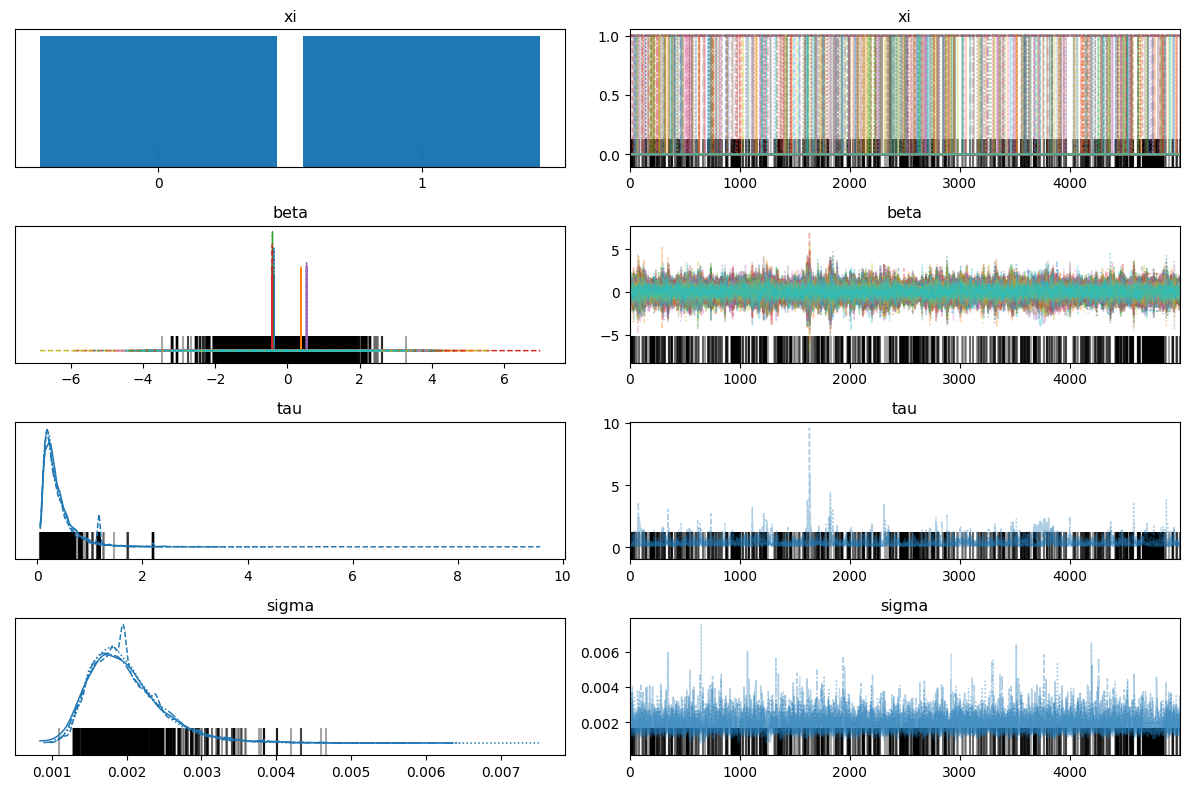

In [7]:
az.plot_trace(trace)
plt.tight_layout()

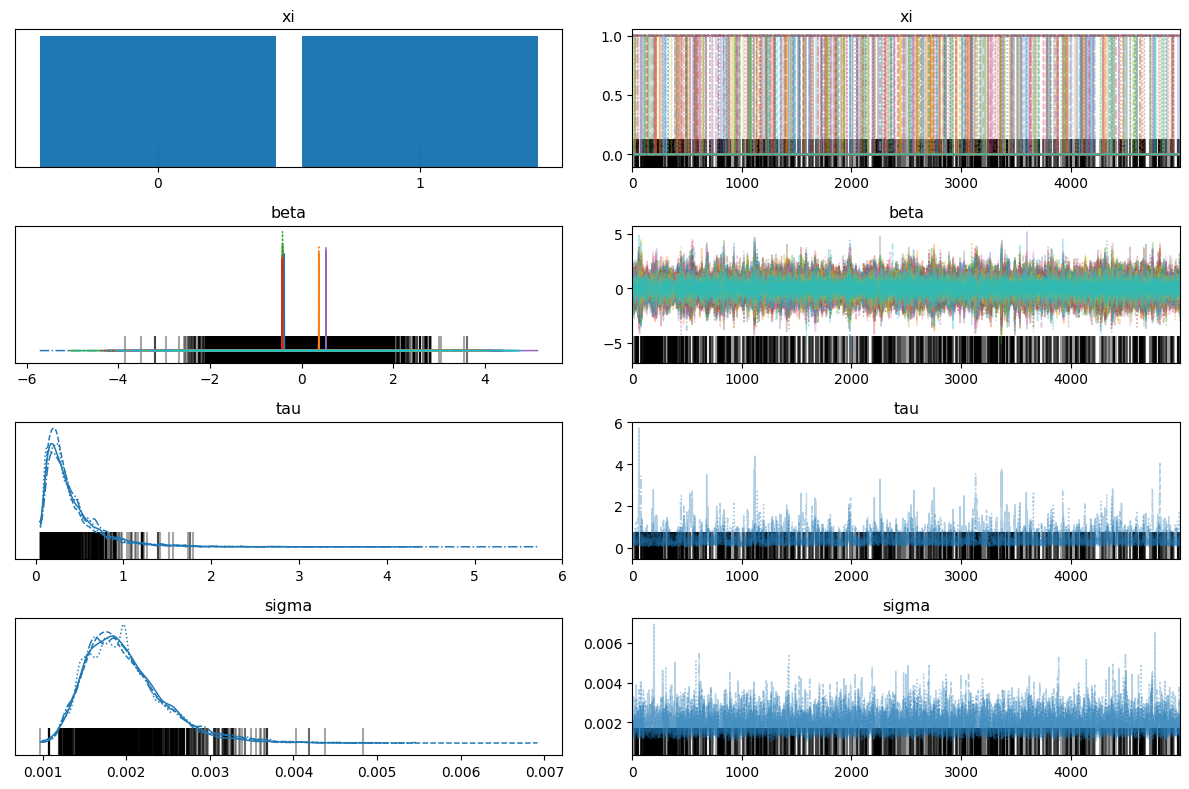

In [8]:
az.plot_trace(idata)
plt.tight_layout()

In [9]:
with model1:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=43)

Sampling: [y_obs]


<AxesSubplot: xlabel='y_obs / y_obs'>

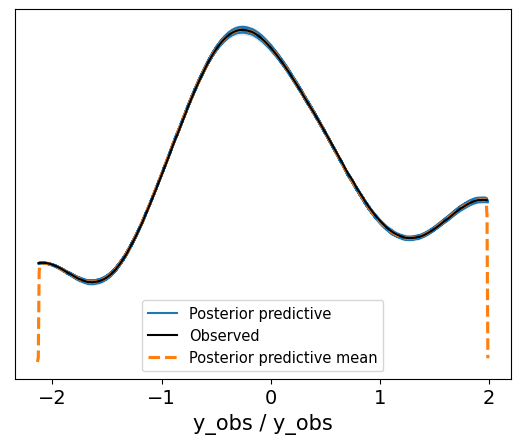

In [10]:
az.plot_ppc(idata)

In [11]:
# az.summary(trace)


In [12]:
results = pd.DataFrame({'var': np.arange(Fcount), 
                        'inclusion_probability':np.mean(np.apply_along_axis(np.mean, 1, trace.posterior['xi']), axis=0),
                       'beta':np.mean(np.apply_along_axis(np.mean, 1, trace.posterior['beta']), axis=0),
                    #    'beta_given_inclusion': np.apply_along_axis(np.sum, 0, trace['xi']*trace['beta'])
                    #         /np.apply_along_axis(np.sum, 0, trace['xi'])
                       })

In [13]:
results.sort_values('inclusion_probability', ascending = False).head(10)


,var,inclusion_probability,beta
0,0,1.00000,-0.378237
2,2,1.00000,-0.415328
3,3,1.00000,-0.419178
4,4,1.00000,0.530192
1,1,1.00000,0.373670
33,33,0.02470,-0.062200
6,6,0.00605,-0.020327
7,7,0.00495,-0.000745
19,19,0.00435,-0.054259
34,34,0.00410,0.000961


# 100

In [2]:
Fcount = 100

X,y = CreateRegression(Fcount = Fcount)

(16,)


array([ 1.046e+00,  1.468e+00, -1.465e+00,  8.730e-01, -6.020e-01,
        2.000e-03,  2.000e-03, -2.000e-03,  2.000e-03, -0.000e+00,
       -0.000e+00,  1.000e-03,  1.000e-03,  0.000e+00,  0.000e+00,
        0.000e+00, -0.000e+00, -2.000e-03,  2.000e-03, -0.000e+00,
       -1.000e-03,  0.000e+00,  2.000e-03,  0.000e+00, -1.000e-03,
        1.000e-03,  1.000e-03, -0.000e+00,  1.000e-03,  2.000e-03,
        0.000e+00, -1.000e-03, -1.000e-03, -0.000e+00, -0.000e+00,
        1.000e-03, -1.000e-03, -1.000e-03,  1.000e-03,  1.000e-03,
       -0.000e+00, -2.000e-03, -0.000e+00,  0.000e+00,  2.000e-03,
       -0.000e+00, -0.000e+00, -1.000e-03,  0.000e+00, -0.000e+00,
       -1.000e-03, -1.000e-03,  1.000e-03, -1.000e-03,  1.000e-03,
        1.000e-03,  2.000e-03,  1.000e-03,  1.000e-03, -0.000e+00,
        2.000e-03,  2.000e-03,  2.000e-03,  0.000e+00,  0.000e+00,
        1.000e-03, -1.000e-03,  0.000e+00,  0.000e+00])

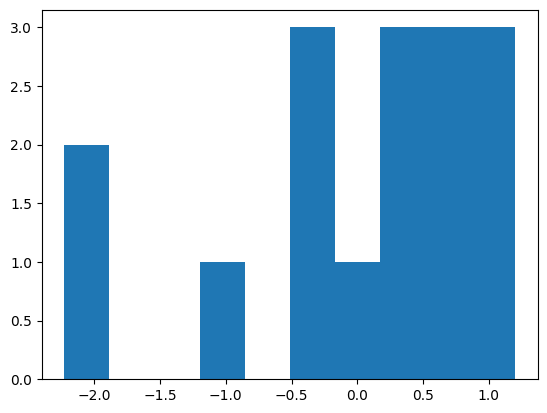

In [3]:
print(y.shape)
plt.hist(y)

W.round(3)

In [5]:
model1 = get_model(y, X)
# model1 = get_model(y.to_numpy(), X.to_numpy())


with model1:
    trace = pm.sample(5000, tune=500, random_seed = 4816, cores = None, progressbar = True, chains = None, target_accept=0.95)
    idata = pm.sample_prior_predictive(samples=50, random_seed=43)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [xi]
>NUTS: [tau, sigma, beta]


Sampling 4 chains for 500 tune and 5_000 draw iterations (2_000 + 20_000 draws total) took 6873 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 5443 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [beta, sigma, tau, xi, y_obs]


In [6]:
with model1:
    idata.extend(pm.sample(5000, tune=500, random_seed=43, target_accept=0.95))

# az.plot_trace(idata)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [xi]
>NUTS: [tau, sigma, beta]


Sampling 4 chains for 500 tune and 5_000 draw iterations (2_000 + 20_000 draws total) took 5990 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 5605 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


/cluster/home/jmcint09/condaenv/testenv/lib/python3.8/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/cluster/home/jmcint09/condaenv/testenv/lib/python3.8/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/cluster/home/jmcint09/condaenv/testenv/lib/python3.8/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


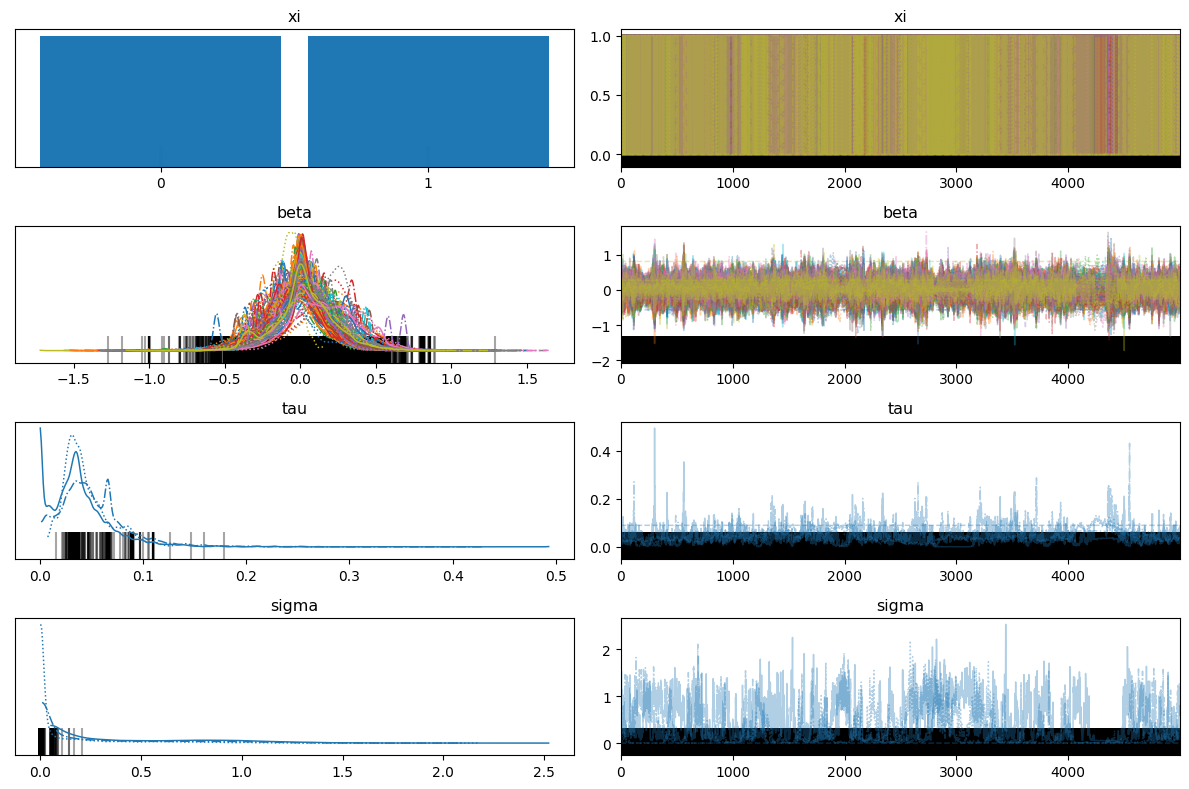

In [7]:
az.plot_trace(trace)
plt.tight_layout()

/cluster/home/jmcint09/condaenv/testenv/lib/python3.8/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/cluster/home/jmcint09/condaenv/testenv/lib/python3.8/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/cluster/home/jmcint09/condaenv/testenv/lib/python3.8/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


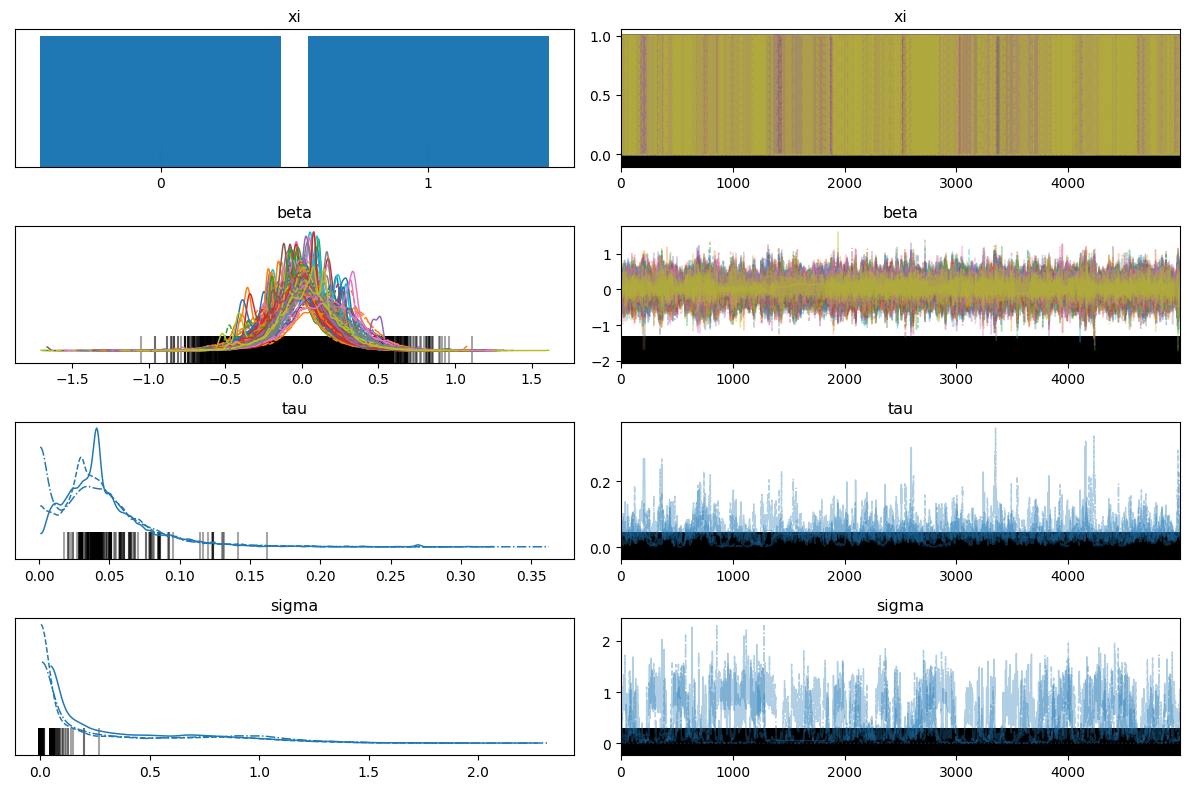

In [8]:
az.plot_trace(idata)
plt.tight_layout()

In [9]:
with model1:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=43)

Sampling: [y_obs]


<AxesSubplot: xlabel='y_obs / y_obs'>

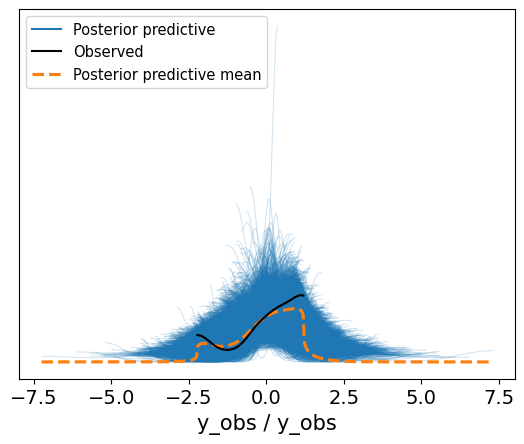

In [10]:
az.plot_ppc(idata)

In [11]:
# az.summary(trace)


In [12]:
results = pd.DataFrame({'var': np.arange(Fcount), 
                        'inclusion_probability':np.mean(np.apply_along_axis(np.mean, 1, trace.posterior['xi']), axis=0),
                       'beta':np.mean(np.apply_along_axis(np.mean, 1, trace.posterior['beta']), axis=0),
                    #    'beta_given_inclusion': np.apply_along_axis(np.sum, 0, trace['xi']*trace['beta'])
                    #         /np.apply_along_axis(np.sum, 0, trace['xi'])
                       })

In [13]:
results.sort_values('inclusion_probability', ascending = False).head(10)


,var,inclusion_probability,beta
3,3,0.79650,0.183410
1,1,0.76305,0.128878
11,11,0.73215,-0.071603
50,50,0.70800,0.099219
67,67,0.69225,0.135274
30,30,0.68895,-0.208722
37,37,0.66815,0.034517
56,56,0.66730,0.120329
13,13,0.66555,0.091206
2,2,0.66370,-0.125840
